### Harmonic mean convergence testing 

Continuous production params:

|Parameters| values|
|----------|-------|
|q | 500|
|D | 300|
|$\tau$| 35|
|$R_0$ | 0.2|
|$\kappa$ | 0.1|
|m | 3|
|$b_0$ | 0.001|

Number of iterations = 20,000

Initial production params:

|Parameters| values|
|----------|-------|
|q | 50|
|D | 80|
|$\tau$| 35|
|$R_0$ | 0.2|
|$\kappa$ | 0.1|
|m | 3|
|$b_0$ | 0.001|

Number of iterations = 20,000

In [1]:
# allow imports from the LM package
import os
import sys
sys.path.append(os.path.abspath('..'))
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from inference.attractant_inference import AttractantInferer, observed_bias
from in_silico.sources import CellsOnWoundMargin, PointWound, CellsInsideWound
from Utilities.distributions import Normal

matplotlib.rcParams.update({'errorbar.capsize': 4})


In [61]:
Prod_time = np.load('../data/Synthetic_Data/Synth_attract_cons_time.npy', allow_pickle=True)
Constant_conc  = np.load('../data/Synthetic_Data/Synth_attract_constant_conc_init.npy', allow_pickle=True)

constant_conc_params = Constant_conc[0].get_chain(flat = True, discard = 500)
prod_time_params = Prod_time[0].get_chain(flat = True, discard = 500)


np.mean(constant_conc_params[0]),np.mean(constant_conc_params[1])


(25.838693332097524, 604.0213520958279)

In [62]:
def HME(sampler,n_discards,n_samples):
    log_probs = sampler.get_log_prob(flat = False,discard = n_discards)
    log_prob = log_probs[:n_samples,:] #(n_iterations,n_walkers)
    probs = np.exp(log_prob.flatten())
    HME = 1 / np.mean(1/probs)
    return HME

HME1 = HME(Prod_time[0],10000,10000)
HME2 = HME(Constant_conc[0],10000,10000)

print("PT model evidence = {:.2E},IC model evidence = {:.2E}".format(HME1,HME2))
#print("Model Evidence for PT: ","{:e}".format(HME1 - HME2))

PT model evidence = 5.00E+22,IC model evidence = 5.13E+11


In [27]:
log_probs = Prod_time[0].get_log_prob(flat = False,discard = 500)
np.shape(log_probs)

(19500, 80)

In [65]:
print("IC mean acceptance rate is: {0:1.2f}".format(np.mean(Constant_conc[0].acceptance_fraction)))
print("PT mean acceptance rate is: {0:1.2f}".format(np.mean(Prod_time[0].acceptance_fraction)))

IC mean acceptance rate is: 0.14
PT mean acceptance rate is: 0.15


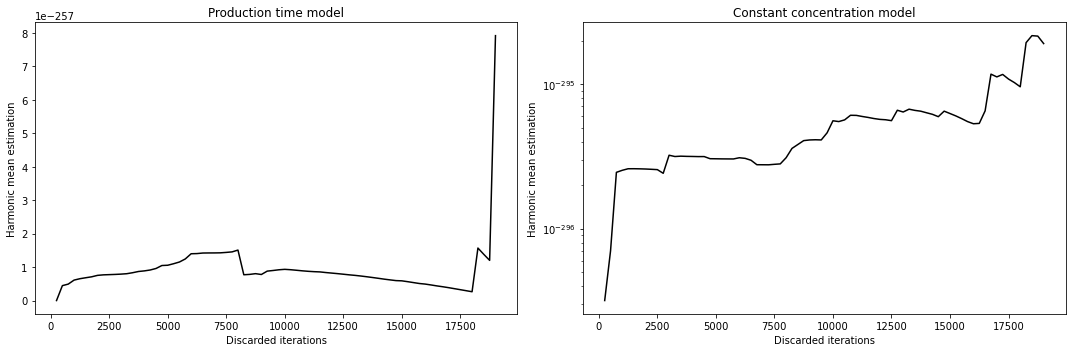

In [28]:

discards = np.arange(250,19250,250)
hme_1 = []
hme_2 = []
for discard in discards:
    hme_1.append(HME(Prod_time[0],discard,10000))
    hme_2.append(HME(Constant_conc[0],discard,10000))
    

fig, axes = plt.subplots(ncols=2, nrows=1,figsize=(15, 5))


axes[0].plot(discards,hme_1,'k')
axes[0].set_xlabel("Discarded iterations")
axes[0].set_ylabel("Harmonic mean estimation")
axes[0].set_title("Production time model")

axes[1].plot(discards,hme_2,'k')
axes[1].set_xlabel("Discarded iterations")
axes[1].set_ylabel("Harmonic mean estimation")
axes[1].set_title("Constant concentration model")


plt.yscale("log")
fig.tight_layout()
plt.show()



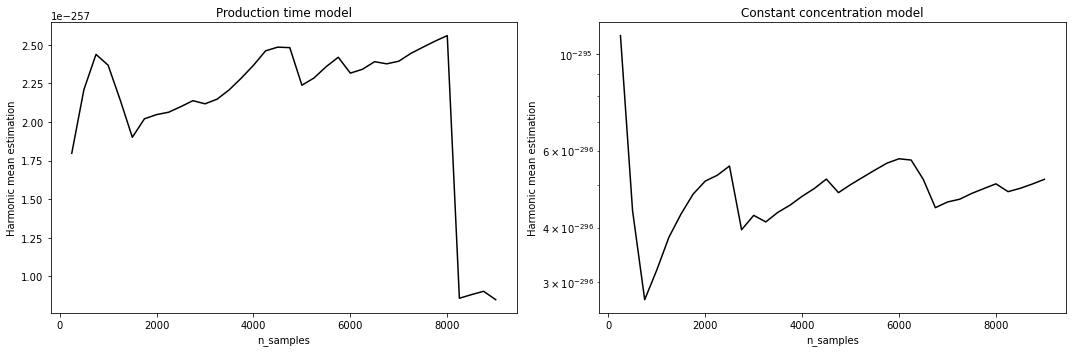

In [29]:
burn_in = 10000
n_samples = np.arange(250,19250-burn_in,250)


hme_1 = []
hme_2 = []
for n_sample in n_samples:
    hme_1.append(HME(Prod_time[0],burn_in,n_sample))
    hme_2.append(HME(Constant_conc[0],burn_in,n_sample))
    

fig, axes = plt.subplots(ncols=2, nrows=1,figsize=(15, 5))


axes[0].plot(n_samples,hme_1,'k')
axes[0].set_xlabel("n_samples")
axes[0].set_ylabel("Harmonic mean estimation")
axes[0].set_title("Production time model")

axes[1].plot(n_samples,hme_2,'k')
axes[1].set_xlabel("n_samples")
axes[1].set_ylabel("Harmonic mean estimation")
axes[1].set_title("Constant concentration model")


plt.yscale("log")
fig.tight_layout()
plt.show()



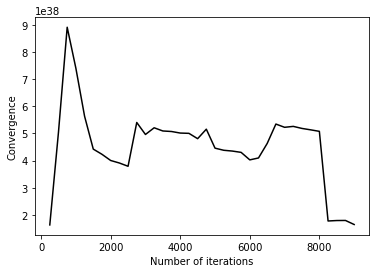

In [30]:
ratio = [hme_1[i]/hme_2[i] for i in range(len(hme_1))]
plt.plot(n_samples, ratio,'k')
plt.xlabel("Number of iterations")
plt.ylabel("Convergence")
plt.show()

In [19]:
sample_size = 1000
discards = 2500
max_size = 20000
n_samples = np.arange(discards,10000+discards,500)
len_n_samples = len(n_samples)
n_random_samples = 100
sample_discard_list_prod = np.zeros((len_n_samples,n_random_samples))
sample_discard_list_init = np.zeros((len_n_samples,n_random_samples))
n_samples

array([ 2500,  3000,  3500,  4000,  4500,  5000,  5500,  6000,  6500,
        7000,  7500,  8000,  8500,  9000,  9500, 10000, 10500, 11000,
       11500, 12000])

In [20]:
for count, sample in enumerate(n_samples):
    for i in range(n_random_samples):
        sample_slice = np.random.randint(discards,(max_size - sample))
        sample_discard_list_prod[count][i] = HME(Prod_time[0],sample_slice,sample)
        sample_discard_list_init[count][i] = HME(Constant_conc[0],sample_slice,sample)



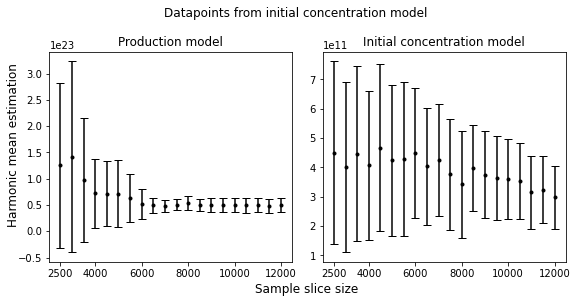

In [21]:
x = np.arange(discards,10000+discards,500)
y_prod = np.mean(sample_discard_list_prod, axis = 1)
err_prod = np.std(sample_discard_list_prod, axis = 1)


y_init = np.mean(sample_discard_list_init, axis = 1)
err_init = np.std(sample_discard_list_init, axis = 1)


x_ticks = np.append([2500],np.arange(4000,13000,2000))
fig,(ax1,ax2) = plt.subplots(1,2, sharex = True,figsize=(8, 4))

fig.suptitle("Datapoints from initial concentration model")
ax1.errorbar(x,y_prod,err_prod, fmt = '.', c = 'k')
ax1.set_title("Production model")


ax2.errorbar(x,y_init,err_init, fmt = '.',c = 'k')

ax2.set_title("Initial concentration model")

plt.xticks(x_ticks)
fig.text(0.43,0, 'Sample slice size', va='center', size = 'large')
fig.text(0, 0.5, 'Harmonic mean estimation', va='center', rotation='vertical',size = 'large')
plt.tight_layout()
plt.savefig("../data/HME_init_errorbars.pdf", bbox_inches="tight")